<a href="https://colab.research.google.com/github/Bennibraun/Microwave-Analysis/blob/master/Particle_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from scipy.stats import multivariate_normal as mvn
from scipy import integrate
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random
import math

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1uLp4WsOXkQS76m0I61UrTibxMt-qSEtC'
downloaded = drive.CreateFile({'id': file_id })
downloaded.GetContentFile('all_data_yeast_particles.xlsx')

# Join single particle-frequency measurements into pseudo-multi-frequency particles

In [ ]:
freqs = ['7.65GHz','5.55GHz','3.96GHz','2.38GHz','0.8GHz']
types = ['5.5um','3um']

cols = ['Type']
for freq in freqs:
  cols += [freq+'_Re']
  cols += [freq+'_Im']

df = pd.DataFrame(columns=cols)


# First, we need to determine the number of rows per particle size
# In order to avoid truncating the end of our data
max_size = 0
type_sizes = [0]*len(types)
for type in range(len(types)):
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(13+(type*3),15+(type*3)))
    
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    if max_size<len(newdf):
      max_size = len(newdf)
  
  type_sizes[type] = max_size
  max_size = 0


# Gather particle measurements from all sheets together
# Scrap time measurements for the pseudo-combination of frequencies
typedf = df.copy(deep=True)
for type in range(len(types)):
  typedf = typedf.iloc[0:0]
  typedf['Type'] = pd.Series(data=[types[type]]*type_sizes[type])
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(13+(type*3),15+(type*3)))
  
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    typedf[freq+'_Re'] = pd.Series(newdf['Epsilon_Re'].values)
    typedf[freq+'_Im'] = pd.Series(newdf['Epsilon_Im'].values)


  df = pd.concat([df,typedf],ignore_index=True)



# Since the multi-frequency measurements are falsely associated anyway,
# We now randomly duplicate readings to fill in the gaps
for type in range(len(types)):
  for col in cols[1:]:
    # Isolate the column/type's valid values into a series for random selection
    col_series = df[col].loc[df['Type'] == types[type]].loc[df[col].notnull()]

    while df[col].loc[df['Type'] == types[type]].isnull().values.any():
      # Get random row
      rand_val = col_series.sample()

      # Place this random value into the next empty cell in the column
      next_nan = df[col].loc[df['Type'] == types[type]].loc[df[col].isnull()].index[0]
      df.at[next_nan,col] = rand_val.values[0]


# pd.set_option('display.max_rows',50)
df



,Type,7.65GHz_Re,7.65GHz_Im,5.55GHz_Re,5.55GHz_Im,3.96GHz_Re,3.96GHz_Im,2.38GHz_Re,2.38GHz_Im,0.8GHz_Re,0.8GHz_Im
0,5.5um,0.553,0.204,0.610,0.182,0.671,0.113,0.685,0.040,0.731,0.0
1,5.5um,0.658,0.203,0.562,0.156,0.659,0.108,0.595,0.045,0.705,0.0
2,5.5um,0.651,0.194,0.594,0.150,0.664,0.118,0.748,0.048,0.706,0.0
3,5.5um,0.623,0.204,0.695,0.185,0.697,0.100,0.645,0.047,0.680,0.0
4,5.5um,0.623,0.216,0.624,0.176,0.674,0.117,0.648,0.039,0.766,0.0
...,...,...,...,...,...,...,...,...,...,...,...
306,3um,0.207,0.122,0.087,0.000,0.137,0.000,0.127,0.000,0.150,0.0
307,3um,0.152,0.117,0.095,0.000,0.112,0.000,0.117,0.000,0.150,0.0
308,3um,0.088,0.114,0.111,0.000,0.079,0.000,0.101,0.000,0.160,0.0
309,3um,0.143,0.107,0.114,0.000,0.154,0.000,0.131,0.000,0.190,0.0


# Create Model

In [ ]:
# Test: uncomment to mess up the data, scramble the labels
# df.Type = np.random.permutation(df.Type)
# df

Training set score: 0.9036585365853659
Test set score: 0.8929440389294404


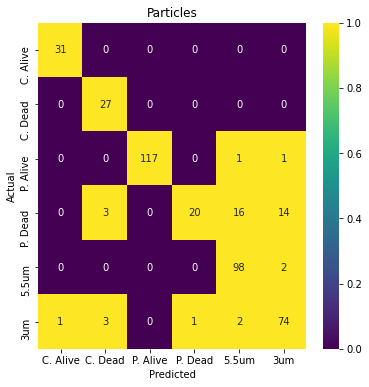

In [ ]:

def make_lr_model(df):
  # Get lists of the necessary values
  x = df.copy(deep=True)
  x = x.drop('Type',axis=1)
  x = x.values.tolist()

  y = df.copy(deep=True)
  y = y['Type']
  y = y.values.tolist()

  # Split into training and test sets
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

  # Scale the data
  scaler = StandardScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)


  # Create the model and fit the data
  # TODO: Fiddle with C and lasso/ridge regressions to get better results
  # Need to use cross-validation to examine results
  # Basically I'll be looping through values of C to determine best performance
  # C controls regularization strength, which helps to prevent overfitting
  # Look into Feature Selection techniques to help determine best frequencies
  # https://scikit-learn.org/stable/modules/feature_selection.html
  # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
  model = LR(solver='liblinear', C=0.05, multi_class='ovr', random_state=0)
  model.fit(x_train, y_train)

  # Generate predictions from test data
  y_pred = model.predict(x_test)

  # Get model scores
  print('Training set score: ',end='')
  print(model.score(x_train, y_train))
  print('Test set score: ',end='')
  print(model.score(x_test, y_test))

  # Confusion matrix to evaluate model
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(6,6))

  sns.heatmap(cm,annot=True,ax=ax,vmin=0,vmax=1,cmap='viridis',fmt='g')

  ax.grid(False)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Particles')
  ax.xaxis.set_ticklabels(types)
  ax.yaxis.set_ticklabels(types)

  sns.despine(left=True, bottom=True, right=True,ax=ax)

make_lr_model(df)


# Visualization at different frequencies

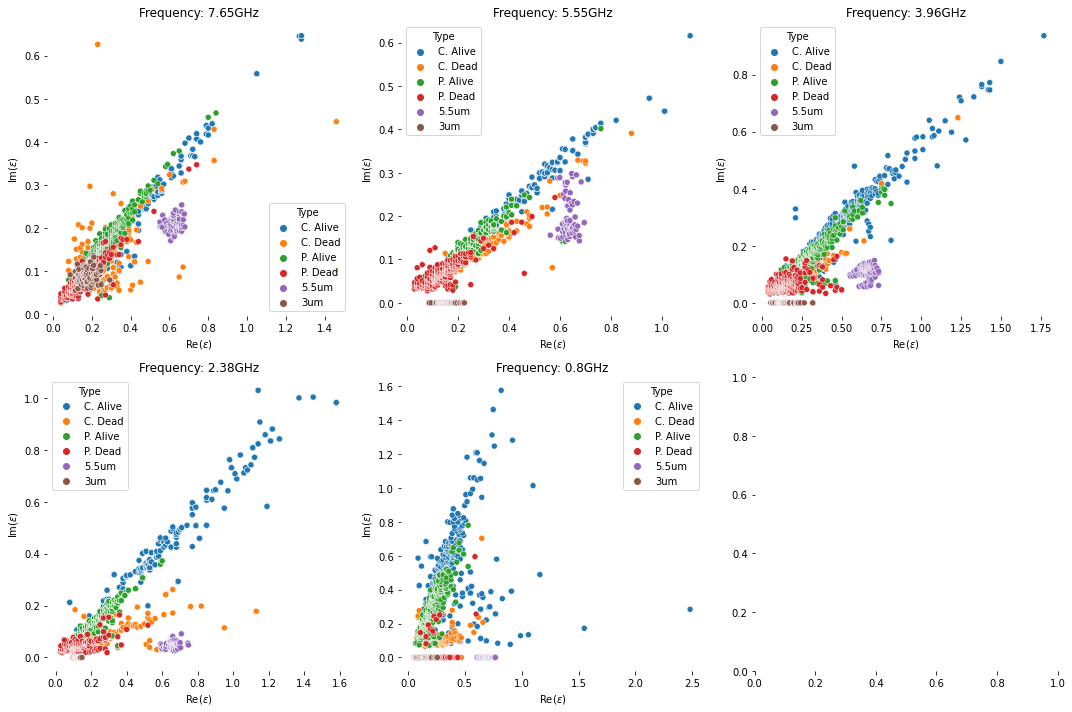

In [ ]:

def plot_lr_coefs(ax,data,freq):
  sns.scatterplot(data=data, x=freq+'_Re',y=freq+'_Im', hue='Type', ax=ax)

  ax.set_ylabel('Im($\epsilon$)')
  ax.set_xlabel('Re($\epsilon$)')

  sns.despine(left=True, bottom=True, right=True)
  # ax.legend().set_visible(False)

  ax.title.set_text(f'Frequency: {freq}')

f, axes = plt.subplots(2,3,figsize=(15,10))


# for plot in range(len(cols)):
#   axes.append(plt.subplots)

for ii,ax in enumerate(axes.flat):
  try:
    freq = cols[1+(ii*2)][:-3]
    # print(df[['Type',freq+'_Re',freq+'_Im']])
    plot_lr_coefs(ax,df[['Type',freq+'_Re',freq+'_Im']],cols[1+(ii*2)][:-3])
  except:
    pass

f.tight_layout()

# Particle-Cell Comparison - Random join

Training set score: 0.8634146341463415
Test set score: 0.8637469586374696


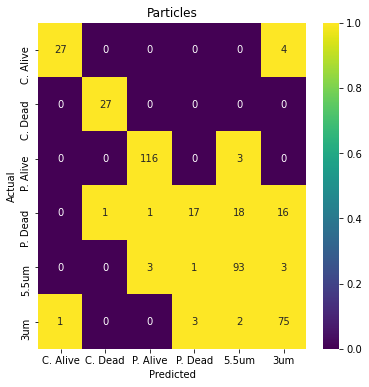

In [ ]:
freqs = ['7.65GHz','5.55GHz','3.96GHz','2.38GHz','0.8GHz']
types = ['C. Alive','C. Dead','P. Alive','P. Dead','5.5um','3um']

cols = ['Type']
for freq in freqs:
  cols += [freq+'_Re']
  cols += [freq+'_Im']

df = pd.DataFrame(columns=cols)


# First, we need to determine the number of rows per particle size
# In order to avoid truncating the end of our data
max_size = 0
type_sizes = [0]*len(types)
for type in range(len(types)):
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
    
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    if max_size<len(newdf):
      max_size = len(newdf)
  
  type_sizes[type] = max_size
  max_size = 0


# Gather particle measurements from all sheets together
# Scrap time measurements for the pseudo-combination of frequencies
typedf = df.copy(deep=True)
for type in range(len(types)):
  typedf = typedf.iloc[0:0]
  typedf['Type'] = pd.Series(data=[types[type]]*type_sizes[type])
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
  
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    typedf[freq+'_Re'] = pd.Series(newdf['Epsilon_Re'].values)
    typedf[freq+'_Im'] = pd.Series(newdf['Epsilon_Im'].values)


  df = pd.concat([df,typedf],ignore_index=True)



# Since the multi-frequency measurements are falsely associated anyway,
# We now randomly duplicate readings to fill in the gaps
for type in range(len(types)):
  for col in cols[1:]:
    # Isolate the column/type's valid values into a series for random selection
    col_series = df[col].loc[df['Type'] == types[type]].loc[df[col].notnull()]

    while df[col].loc[df['Type'] == types[type]].isnull().values.any():
      # Get random row
      rand_val = col_series.sample()

      # Place this random value into the next empty cell in the column
      next_nan = df[col].loc[df['Type'] == types[type]].loc[df[col].isnull()].index[0]
      df.at[next_nan,col] = rand_val.values[0]


pd.set_option('display.max_rows',100)
df


make_lr_model(df)

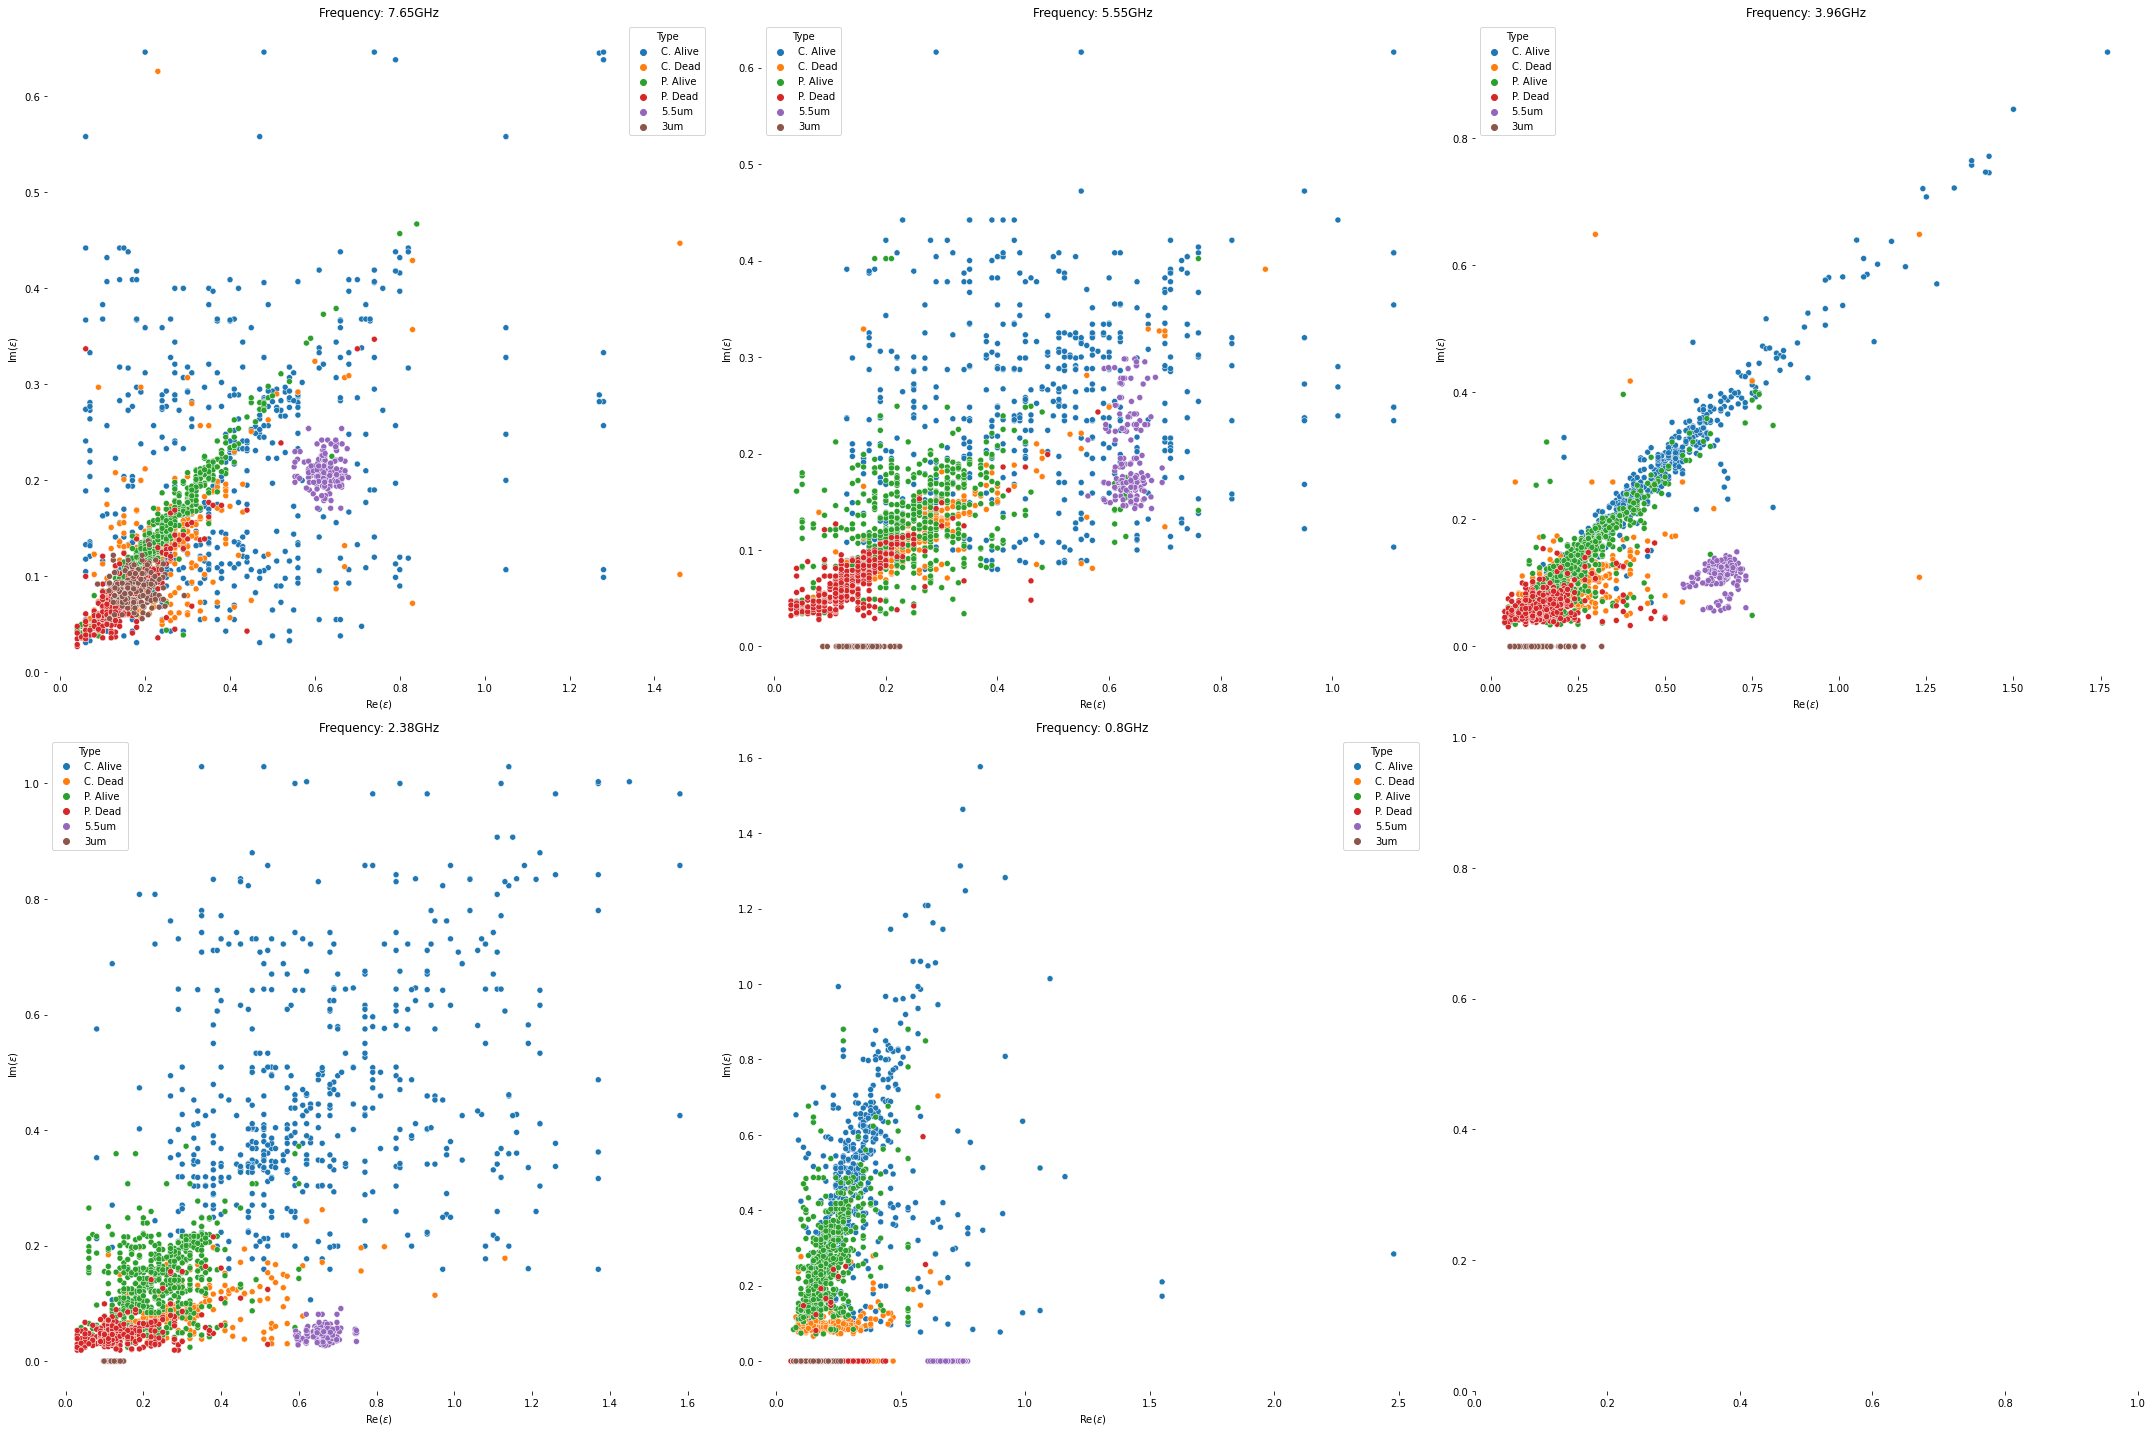

In [ ]:
f, axes = plt.subplots(2,3,figsize=(30,20))


# for plot in range(len(cols)):
#   axes.append(plt.subplots)

for ii,ax in enumerate(axes.flat):
  try:
    freq = cols[1+(ii*2)][:-3]
    # print(df[['Type',freq+'_Re',freq+'_Im']])
    plot_lr_coefs(ax,df[['Type',freq+'_Re',freq+'_Im']],cols[1+(ii*2)][:-3])
  except:
    pass

f.tight_layout()

# Particle-Cell Comparison - Join by Sum

Training set score: 0.9189024390243903
Test set score: 0.927007299270073


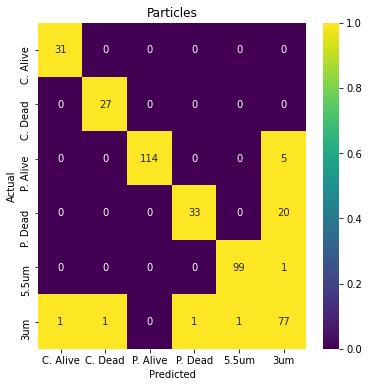

In [ ]:
freqs = ['7.65GHz','5.55GHz','3.96GHz','2.38GHz','0.8GHz']
types = ['C. Alive','C. Dead','P. Alive','P. Dead','5.5um','3um']

cols = ['Type']
for freq in freqs:
  cols += [freq+'_Re']
  cols += [freq+'_Im']

df = pd.DataFrame(columns=cols)


# First, we need to determine the number of rows per particle size
# In order to avoid truncating the end of our data
max_size = 0
type_sizes = [0]*len(types)
for type in range(len(types)):
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
    
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)
    

    if max_size<len(newdf):
      max_size = len(newdf)
  
  type_sizes[type] = max_size
  max_size = 0


# Gather particle measurements from all sheets together
# Scrap time measurements for the pseudo-combination of frequencies
typedf = df.copy(deep=True)
for type in range(len(types)):
  typedf = typedf.iloc[0:0]
  typedf['Type'] = pd.Series(data=[types[type]]*type_sizes[type])
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
  
    # newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    # Fill in rows until the df length matches the type size
    if len(newdf) > type_sizes[type]:
      newdf = newdf[:type_sizes[type]]
    # print(str(len(newdf)))
    # print('number above should be <= ' +str(type_sizes[type]))
    # print('creating padding frame with size ' + str(type_sizes[type]-len(newdf)))
    padding_df = pd.DataFrame(index=range(type_sizes[type]-len(newdf)),columns=['Epsilon_Re','Epsilon_Im'])
    # print(padding_df)
    newdf = newdf.append(padding_df)
    # print(newdf)
    # while len(newdf) < type_sizes[type]:
    #   newdf.append(pd.Series(data=[np.nan,np.nan]), ignore_index=True)
    #   print(str(len(newdf))+ ' < ' + str(type_sizes[type]))

    valid_series = newdf.loc[newdf['Epsilon_Im'].notnull()]
    # print('type: '+types[type])
    # print('type size: '+str(type_sizes[type]))
    # print('valid series: '+str(len(valid_series)))
    # print('whole series: '+str(len(newdf.index)))

    while newdf.isnull().values.any():

      rand_val = valid_series.sample()
      next_nan = newdf.loc[newdf['Epsilon_Im'].isnull()].index[0]
      # print(newdf.loc[next_nan])
      # print(rand_val.values[0])
      newdf.loc[next_nan] = rand_val.values[0]
      # print(newdf.loc[next_nan])



    # cols = ['Epsilon_Re','Epsilon_Im']
    # for col in cols:
    #   # Isolate the column/type's valid values into a series for random selection
    #   col_series = newdf[col].loc[newdf[col].notnull()]
    #   # print(newdf[col])

    #   while newdf[col].isnull().values.any():
    #     # Get random row
    #     rand_val = col_series.sample()

    #     # Place this random value into the next empty cell in the column
    #     next_nan = newdf[col].loc[newdf[col].isnull()].index[0]
    #     newdf.at[next_nan,col] = rand_val.values[0]
    
    # Sort the df low to high by sum of the two measurements
    newdf = newdf.assign(f = newdf['Epsilon_Re'] + newdf['Epsilon_Im']).sort_values('f').drop('f',axis=1)

    typedf[freq+'_Re'] = pd.Series(newdf['Epsilon_Re'].values)
    typedf[freq+'_Im'] = pd.Series(newdf['Epsilon_Im'].values)


  df = pd.concat([df,typedf],ignore_index=True)



# Since the multi-frequency measurements are falsely associated anyway,
# We now randomly duplicate readings to fill in the gaps
# for type in range(len(types)):
#   for col in cols[1:]:
#     # Isolate the column/type's valid values into a series for random selection
#     col_series = df[col].loc[df['Type'] == types[type]].loc[df[col].notnull()]

#     while df[col].loc[df['Type'] == types[type]].isnull().values.any():
#       # Get random row
#       rand_val = col_series.sample()

#       # Place this random value into the next empty cell in the column
#       next_nan = df[col].loc[df['Type'] == types[type]].loc[df[col].isnull()].index[0]
#       df.at[next_nan,col] = rand_val.values[0]


# pd.set_option('display.max_rows',50)
# df


make_lr_model(df)

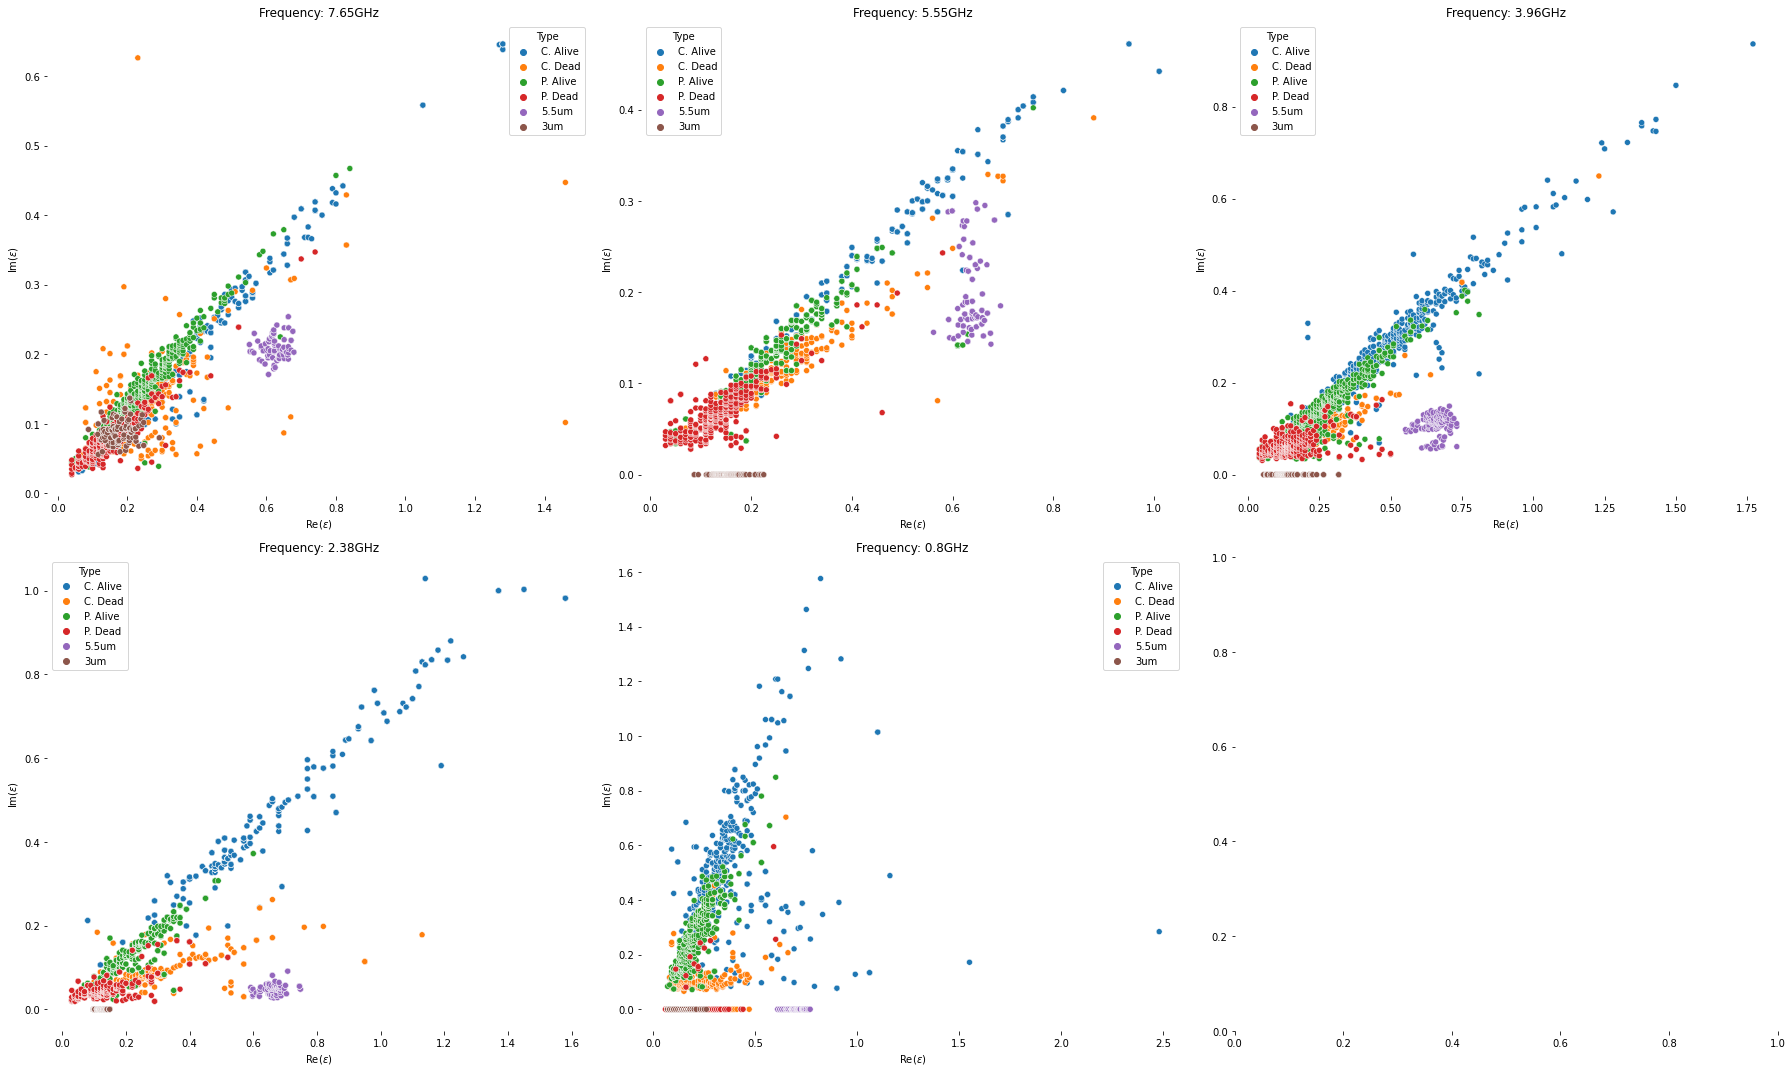

In [ ]:
f, axes = plt.subplots(2,3,figsize=(25,15))


# for plot in range(len(cols)):
#   axes.append(plt.subplots)

for ii,ax in enumerate(axes.flat):
  try:
    freq = cols[1+(ii*2)][:-3]
    # print(df[['Type',freq+'_Re',freq+'_Im']])
    plot_lr_coefs(ax,df[['Type',freq+'_Re',freq+'_Im']],cols[1+(ii*2)][:-3])
  except:
    pass

f.tight_layout()

# Particle-Cell Comparison - Join by Absolute Value

Training set score: 0.9451219512195121
Test set score: 0.9513381995133819


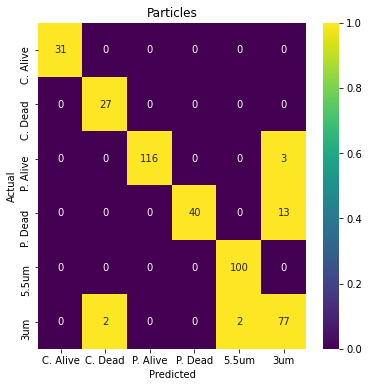

In [ ]:
freqs = ['7.65GHz','5.55GHz','3.96GHz','2.38GHz','0.8GHz']
types = ['C. Alive','C. Dead','P. Alive','P. Dead','5.5um','3um']

cols = ['Type']
for freq in freqs:
  cols += [freq+'_Re']
  cols += [freq+'_Im']

df = pd.DataFrame(columns=cols)


# First, we need to determine the number of rows per particle size
# In order to avoid truncating the end of our data
max_size = 0
type_sizes = [0]*len(types)
for type in range(len(types)):
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
    
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)
    

    if max_size<len(newdf):
      max_size = len(newdf)
  
  type_sizes[type] = max_size
  max_size = 0


# Gather particle measurements from all sheets together
# Scrap time measurements for the pseudo-combination of frequencies
typedf = df.copy(deep=True)
for type in range(len(types)):
  typedf = typedf.iloc[0:0]
  typedf['Type'] = pd.Series(data=[types[type]]*type_sizes[type])
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
  
    # newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    # Fill in rows until the df length matches the type size
    if len(newdf) > type_sizes[type]:
      newdf = newdf[:type_sizes[type]]
    # print(str(len(newdf)))
    # print('number above should be <= ' +str(type_sizes[type]))
    # print('creating padding frame with size ' + str(type_sizes[type]-len(newdf)))
    padding_df = pd.DataFrame(index=range(type_sizes[type]-len(newdf)),columns=['Epsilon_Re','Epsilon_Im'])
    # print(padding_df)
    newdf = newdf.append(padding_df)
    # print(newdf)
    # while len(newdf) < type_sizes[type]:
    #   newdf.append(pd.Series(data=[np.nan,np.nan]), ignore_index=True)
    #   print(str(len(newdf))+ ' < ' + str(type_sizes[type]))

    valid_series = newdf.loc[newdf['Epsilon_Im'].notnull()]
    # print('type: '+types[type])
    # print('type size: '+str(type_sizes[type]))
    # print('valid series: '+str(len(valid_series)))
    # print('whole series: '+str(len(newdf.index)))

    while newdf.isnull().values.any():

      rand_val = valid_series.sample()
      next_nan = newdf.loc[newdf['Epsilon_Im'].isnull()].index[0]
      # print(newdf.loc[next_nan])
      # print(rand_val.values[0])
      newdf.loc[next_nan] = rand_val.values[0]
      # print(newdf.loc[next_nan])



    # cols = ['Epsilon_Re','Epsilon_Im']
    # for col in cols:
    #   # Isolate the column/type's valid values into a series for random selection
    #   col_series = newdf[col].loc[newdf[col].notnull()]
    #   # print(newdf[col])

    #   while newdf[col].isnull().values.any():
    #     # Get random row
    #     rand_val = col_series.sample()

    #     # Place this random value into the next empty cell in the column
    #     next_nan = newdf[col].loc[newdf[col].isnull()].index[0]
    #     newdf.at[next_nan,col] = rand_val.values[0]
    
    # Sort the df low to high by sum of the two measurements
    newdf = newdf.assign(f = np.sqrt((newdf['Epsilon_Re']**2)+(newdf['Epsilon_Im']**2))).sort_values('f').drop('f',axis=1)

    typedf[freq+'_Re'] = pd.Series(newdf['Epsilon_Re'].values)
    typedf[freq+'_Im'] = pd.Series(newdf['Epsilon_Im'].values)


  df = pd.concat([df,typedf],ignore_index=True)



# Since the multi-frequency measurements are falsely associated anyway,
# We now randomly duplicate readings to fill in the gaps
# for type in range(len(types)):
#   for col in cols[1:]:
#     # Isolate the column/type's valid values into a series for random selection
#     col_series = df[col].loc[df['Type'] == types[type]].loc[df[col].notnull()]

#     while df[col].loc[df['Type'] == types[type]].isnull().values.any():
#       # Get random row
#       rand_val = col_series.sample()

#       # Place this random value into the next empty cell in the column
#       next_nan = df[col].loc[df['Type'] == types[type]].loc[df[col].isnull()].index[0]
#       df.at[next_nan,col] = rand_val.values[0]


# pd.set_option('display.max_rows',50)
# df


make_lr_model(df)

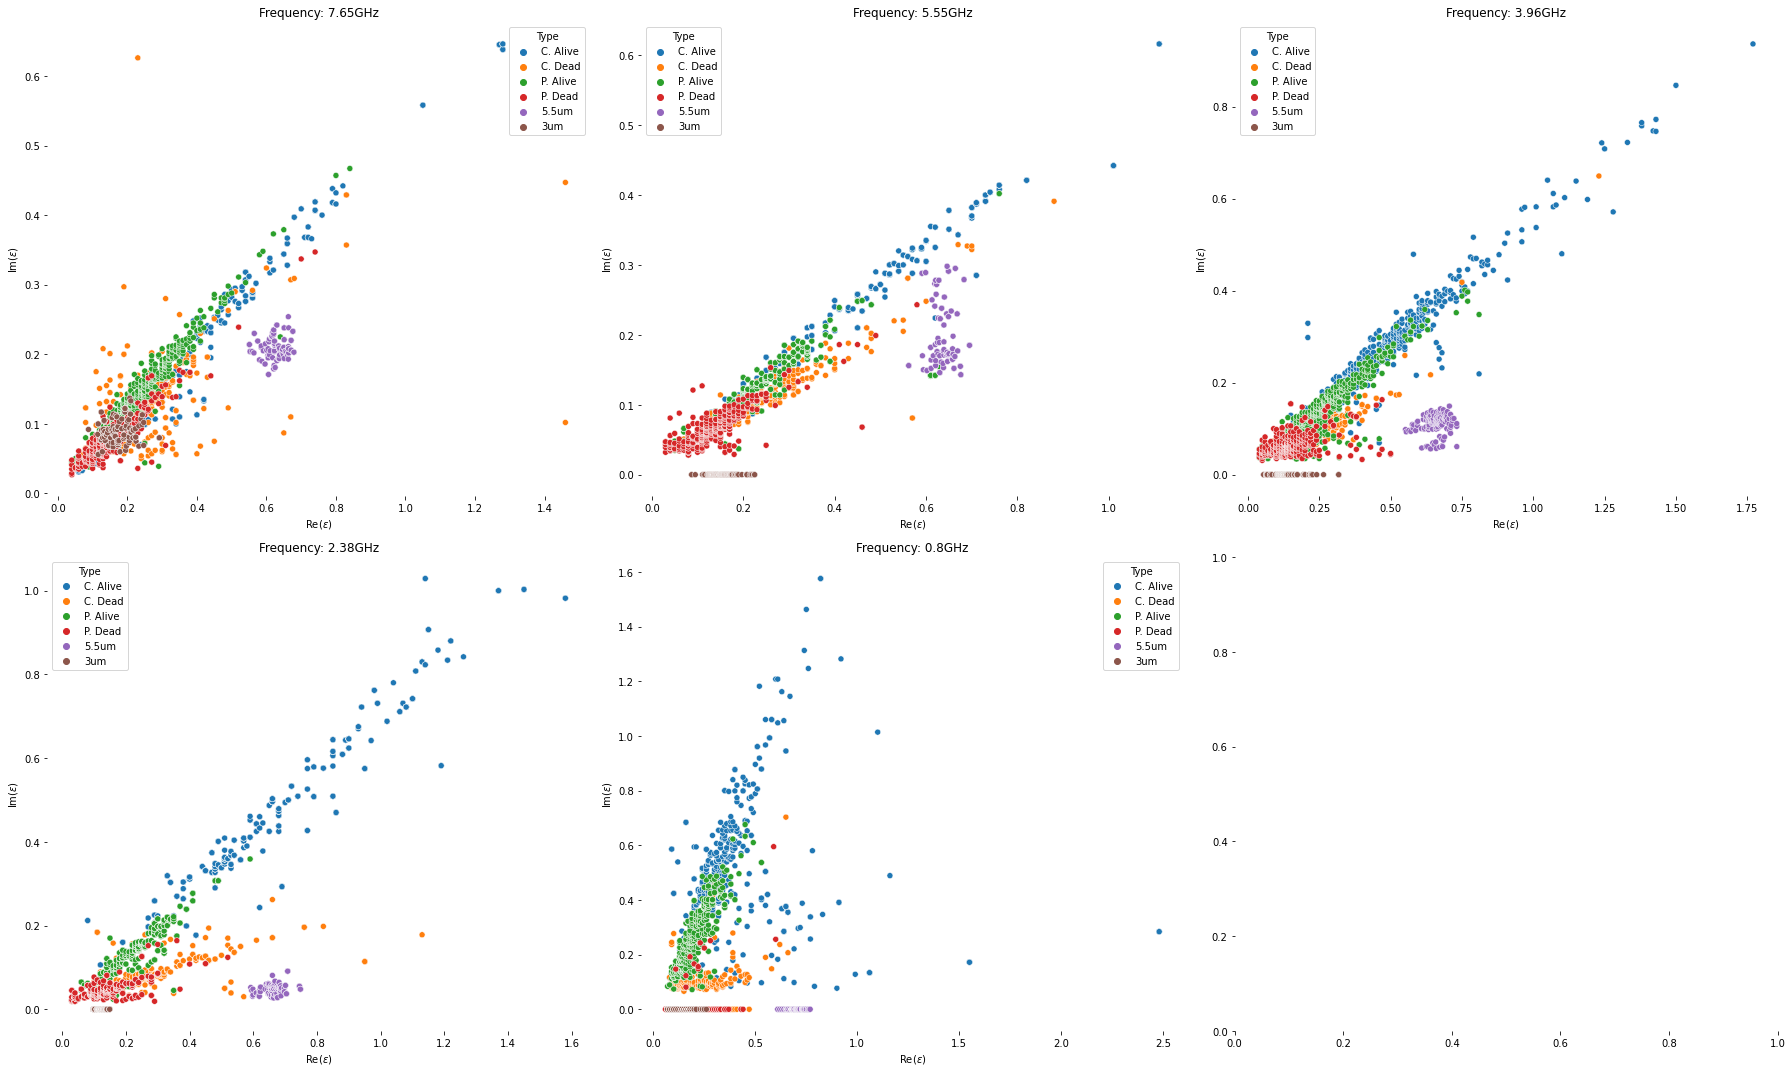

In [ ]:
f, axes = plt.subplots(2,3,figsize=(25,15))


# for plot in range(len(cols)):
#   axes.append(plt.subplots)

for ii,ax in enumerate(axes.flat):
  try:
    freq = cols[1+(ii*2)][:-3]
    # print(df[['Type',freq+'_Re',freq+'_Im']])
    plot_lr_coefs(ax,df[['Type',freq+'_Re',freq+'_Im']],cols[1+(ii*2)][:-3])
  except:
    pass

f.tight_layout()

# Particle-Cell Comparison - Join by -

Training set score: 0.9036585365853659
Test set score: 0.8929440389294404


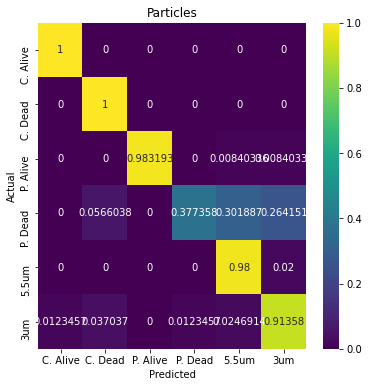

In [ ]:
freqs = ['7.65GHz','5.55GHz','3.96GHz','2.38GHz','0.8GHz']
types = ['C. Alive','C. Dead','P. Alive','P. Dead','5.5um','3um']

cols = ['Type']
for freq in freqs:
  cols += [freq+'_Re']
  cols += [freq+'_Im']

df = pd.DataFrame(columns=cols)


# First, we need to determine the number of rows per particle size
# In order to avoid truncating the end of our data
max_size = 0
type_sizes = [0]*len(types)
for type in range(len(types)):
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
    
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)
    

    if max_size<len(newdf):
      max_size = len(newdf)
  
  type_sizes[type] = max_size
  max_size = 0


# Gather particle measurements from all sheets together
# Scrap time measurements for the pseudo-combination of frequencies
typedf = df.copy(deep=True)
for type in range(len(types)):
  typedf = typedf.iloc[0:0]
  typedf['Type'] = pd.Series(data=[types[type]]*type_sizes[type])
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
  
    # newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    # Fill in rows until the df length matches the type size
    if len(newdf) > type_sizes[type]:
      newdf = newdf[:type_sizes[type]]
    # print(str(len(newdf)))
    # print('number above should be <= ' +str(type_sizes[type]))
    # print('creating padding frame with size ' + str(type_sizes[type]-len(newdf)))
    padding_df = pd.DataFrame(index=range(type_sizes[type]-len(newdf)),columns=['Epsilon_Re','Epsilon_Im'])
    # print(padding_df)
    newdf = newdf.append(padding_df)
    # print(newdf)
    # while len(newdf) < type_sizes[type]:
    #   newdf.append(pd.Series(data=[np.nan,np.nan]), ignore_index=True)
    #   print(str(len(newdf))+ ' < ' + str(type_sizes[type]))

    valid_series = newdf.loc[newdf['Epsilon_Im'].notnull()]
    # print('type: '+types[type])
    # print('type size: '+str(type_sizes[type]))
    # print('valid series: '+str(len(valid_series)))
    # print('whole series: '+str(len(newdf.index)))

    while newdf.isnull().values.any():

      rand_val = valid_series.sample()
      next_nan = newdf.loc[newdf['Epsilon_Im'].isnull()].index[0]
      # print(newdf.loc[next_nan])
      # print(rand_val.values[0])
      newdf.loc[next_nan] = rand_val.values[0]
      # print(newdf.loc[next_nan])



    # cols = ['Epsilon_Re','Epsilon_Im']
    # for col in cols:
    #   # Isolate the column/type's valid values into a series for random selection
    #   col_series = newdf[col].loc[newdf[col].notnull()]
    #   # print(newdf[col])

    #   while newdf[col].isnull().values.any():
    #     # Get random row
    #     rand_val = col_series.sample()

    #     # Place this random value into the next empty cell in the column
    #     next_nan = newdf[col].loc[newdf[col].isnull()].index[0]
    #     newdf.at[next_nan,col] = rand_val.values[0]
    
    # Sort the df low to high by sum of the two measurements
    newdf = newdf.assign(f = (newdf['Epsilon_Re']**2)).sort_values('f').drop('f',axis=1)

    typedf[freq+'_Re'] = pd.Series(newdf['Epsilon_Re'].values)
    typedf[freq+'_Im'] = pd.Series(newdf['Epsilon_Im'].values)


  df = pd.concat([df,typedf],ignore_index=True)



# Since the multi-frequency measurements are falsely associated anyway,
# We now randomly duplicate readings to fill in the gaps
# for type in range(len(types)):
#   for col in cols[1:]:
#     # Isolate the column/type's valid values into a series for random selection
#     col_series = df[col].loc[df['Type'] == types[type]].loc[df[col].notnull()]

#     while df[col].loc[df['Type'] == types[type]].isnull().values.any():
#       # Get random row
#       rand_val = col_series.sample()

#       # Place this random value into the next empty cell in the column
#       next_nan = df[col].loc[df['Type'] == types[type]].loc[df[col].isnull()].index[0]
#       df.at[next_nan,col] = rand_val.values[0]


# pd.set_option('display.max_rows',50)
# df


make_lr_model(df)

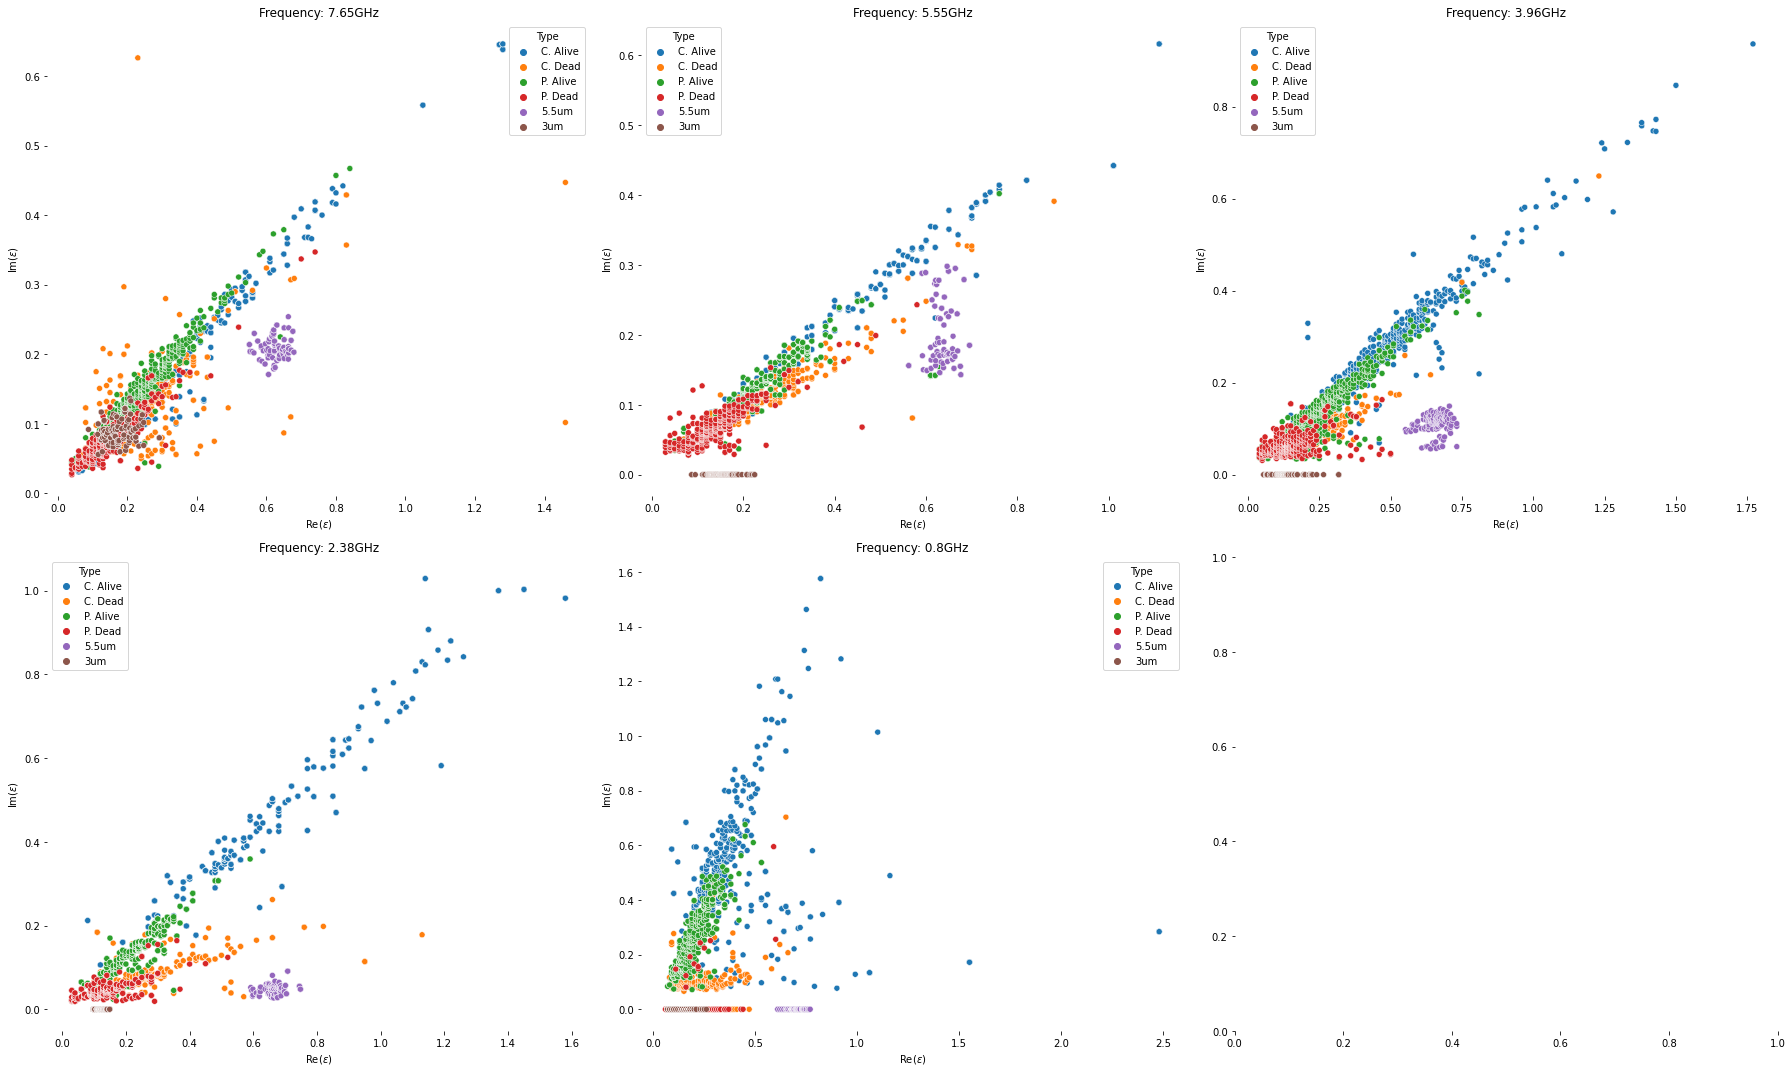

In [ ]:
f, axes = plt.subplots(2,3,figsize=(25,15))


# for plot in range(len(cols)):
#   axes.append(plt.subplots)

for ii,ax in enumerate(axes.flat):
  try:
    freq = cols[1+(ii*2)][:-3]
    # print(df[['Type',freq+'_Re',freq+'_Im']])
    plot_lr_coefs(ax,df[['Type',freq+'_Re',freq+'_Im']],cols[1+(ii*2)][:-3])
  except:
    pass

f.tight_layout()

# Particle-Cell Comparison - Join by Real Component

Training set score: 0.9121951219512195
Test set score: 0.902676399026764


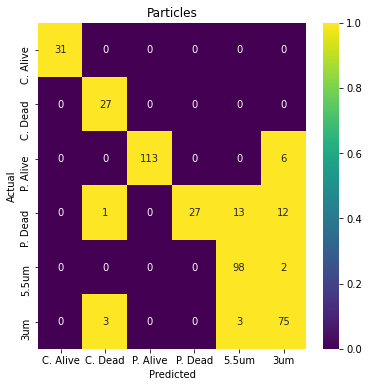

In [ ]:
freqs = ['7.65GHz','5.55GHz','3.96GHz','2.38GHz','0.8GHz']
types = ['C. Alive','C. Dead','P. Alive','P. Dead','5.5um','3um']

cols = ['Type']
for freq in freqs:
  cols += [freq+'_Re']
  cols += [freq+'_Im']

df = pd.DataFrame(columns=cols)


# First, we need to determine the number of rows per particle size
# In order to avoid truncating the end of our data
max_size = 0
type_sizes = [0]*len(types)
for type in range(len(types)):
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
    
    newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)
    

    if max_size<len(newdf):
      max_size = len(newdf)
  
  type_sizes[type] = max_size
  max_size = 0


# Gather particle measurements from all sheets together
# Scrap time measurements for the pseudo-combination of frequencies
typedf = df.copy(deep=True)
for type in range(len(types)):
  typedf = typedf.iloc[0:0]
  typedf['Type'] = pd.Series(data=[types[type]]*type_sizes[type])
  for freq in freqs:
    newdf = pd.read_excel('all_data_yeast_particles.xlsx',
                          header=None,
                          names=['Epsilon_Re','Epsilon_Im'],
                          sheet_name=freq,
                          skiprows=2,
                          usecols=range(1+(type*3),3+(type*3)))
  
    # newdf.dropna(subset=['Epsilon_Re','Epsilon_Im'],inplace=True)

    # Fill in rows until the df length matches the type size
    if len(newdf) > type_sizes[type]:
      newdf = newdf[:type_sizes[type]]
    # print(str(len(newdf)))
    # print('number above should be <= ' +str(type_sizes[type]))
    # print('creating padding frame with size ' + str(type_sizes[type]-len(newdf)))
    padding_df = pd.DataFrame(index=range(type_sizes[type]-len(newdf)),columns=['Epsilon_Re','Epsilon_Im'])
    # print(padding_df)
    newdf = newdf.append(padding_df)
    # print(newdf)
    # while len(newdf) < type_sizes[type]:
    #   newdf.append(pd.Series(data=[np.nan,np.nan]), ignore_index=True)
    #   print(str(len(newdf))+ ' < ' + str(type_sizes[type]))

    valid_series = newdf.loc[newdf['Epsilon_Im'].notnull()]
    # print('type: '+types[type])
    # print('type size: '+str(type_sizes[type]))
    # print('valid series: '+str(len(valid_series)))
    # print('whole series: '+str(len(newdf.index)))

    while newdf.isnull().values.any():

      rand_val = valid_series.sample()
      next_nan = newdf.loc[newdf['Epsilon_Im'].isnull()].index[0]
      # print(newdf.loc[next_nan])
      # print(rand_val.values[0])
      newdf.loc[next_nan] = rand_val.values[0]
      # print(newdf.loc[next_nan])



    # cols = ['Epsilon_Re','Epsilon_Im']
    # for col in cols:
    #   # Isolate the column/type's valid values into a series for random selection
    #   col_series = newdf[col].loc[newdf[col].notnull()]
    #   # print(newdf[col])

    #   while newdf[col].isnull().values.any():
    #     # Get random row
    #     rand_val = col_series.sample()

    #     # Place this random value into the next empty cell in the column
    #     next_nan = newdf[col].loc[newdf[col].isnull()].index[0]
    #     newdf.at[next_nan,col] = rand_val.values[0]
    
    # Sort the df low to high by sum of the two measurements
    newdf.sort_values('Epsilon_Re',inplace=True)

    typedf[freq+'_Re'] = pd.Series(newdf['Epsilon_Re'].values)
    typedf[freq+'_Im'] = pd.Series(newdf['Epsilon_Im'].values)


  df = pd.concat([df,typedf],ignore_index=True)



# Since the multi-frequency measurements are falsely associated anyway,
# We now randomly duplicate readings to fill in the gaps
# for type in range(len(types)):
#   for col in cols[1:]:
#     # Isolate the column/type's valid values into a series for random selection
#     col_series = df[col].loc[df['Type'] == types[type]].loc[df[col].notnull()]

#     while df[col].loc[df['Type'] == types[type]].isnull().values.any():
#       # Get random row
#       rand_val = col_series.sample()

#       # Place this random value into the next empty cell in the column
#       next_nan = df[col].loc[df['Type'] == types[type]].loc[df[col].isnull()].index[0]
#       df.at[next_nan,col] = rand_val.values[0]


# pd.set_option('display.max_rows',50)
# df


make_lr_model(df)

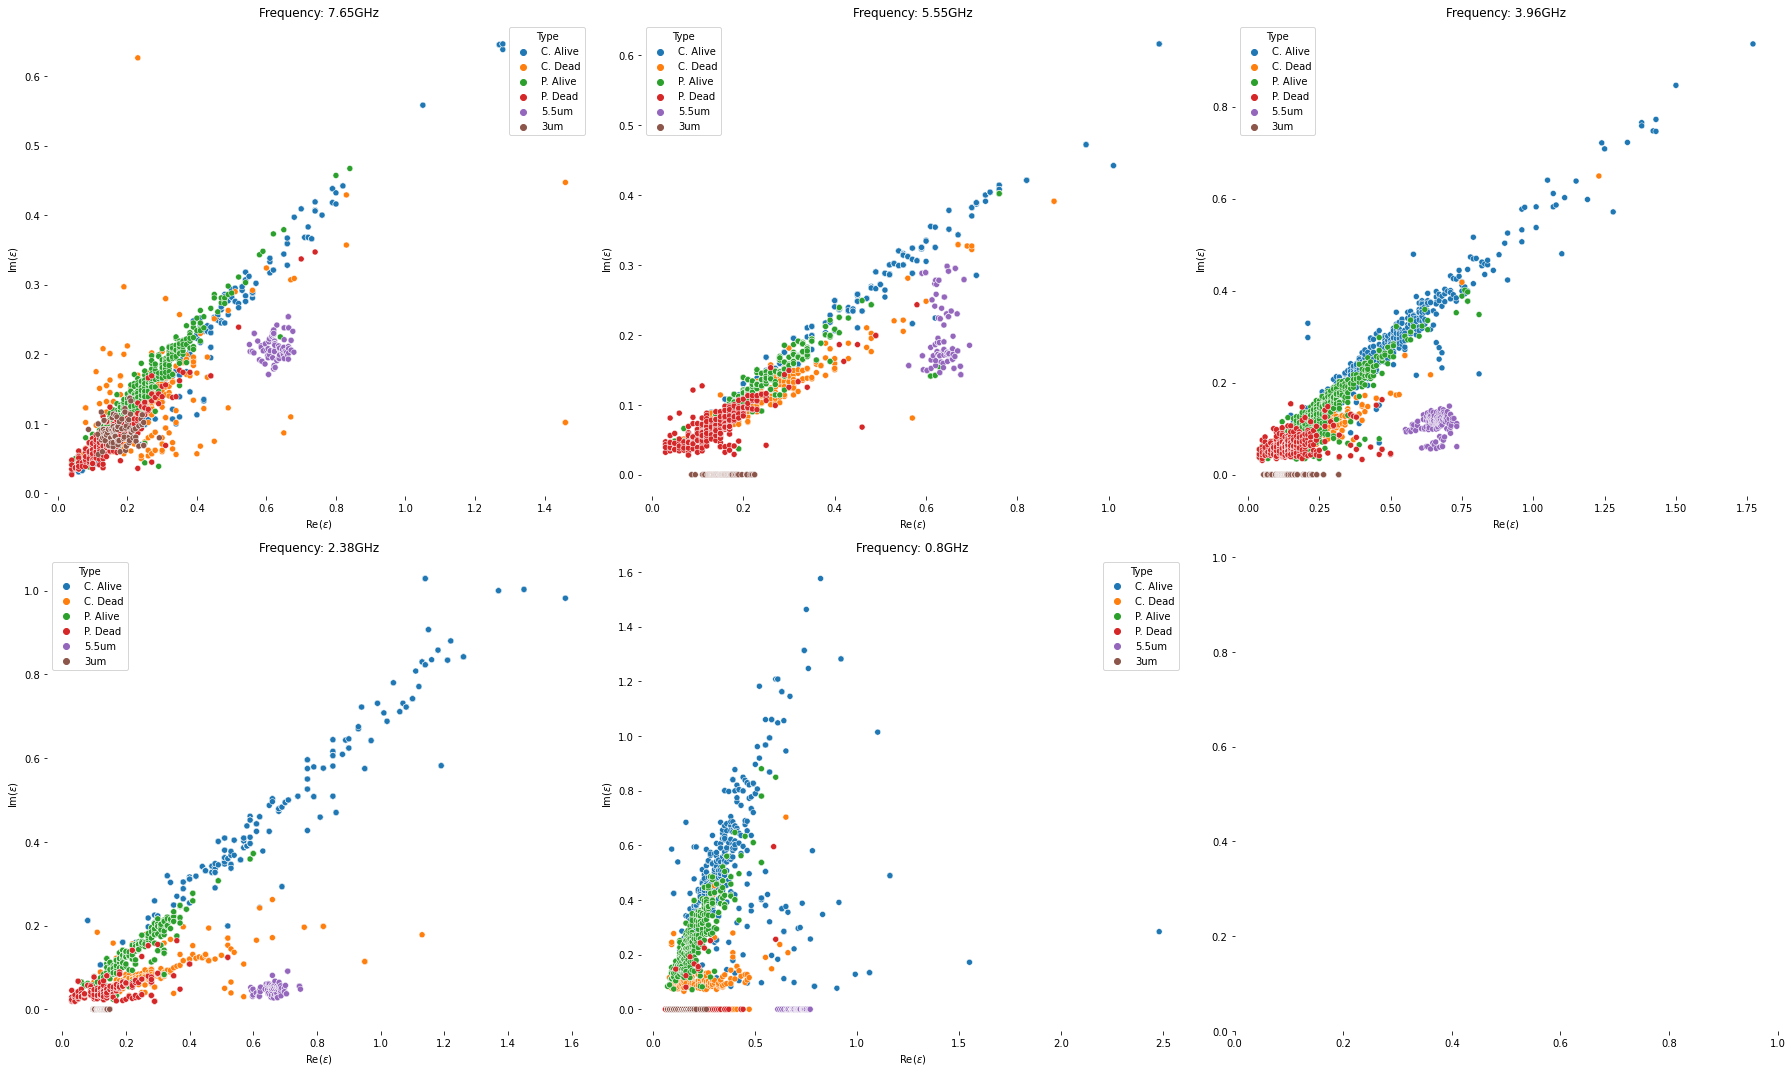

In [ ]:
f, axes = plt.subplots(2,3,figsize=(25,15))


# for plot in range(len(cols)):
#   axes.append(plt.subplots)

for ii,ax in enumerate(axes.flat):
  try:
    freq = cols[1+(ii*2)][:-3]
    # print(df[['Type',freq+'_Re',freq+'_Im']])
    plot_lr_coefs(ax,df[['Type',freq+'_Re',freq+'_Im']],cols[1+(ii*2)][:-3])
  except:
    pass

f.tight_layout()